# State space modeling for the annual flow of river Nile

The first part of this project considers the use of state space models for hydrology applications. The dataset nile.csv contains measurements of the annual flow (in unit of 108 × m3) of the river Nile at Aswan between 1871 to 1970 (source: Table 1 of Cobb 1978).

## 1. Read the river Nile dataset using the read_csv function from the pandas package

In [93]:
import pandas as pd 

dataset = pd.read_csv('nile.csv')
dataset.head()

,flow
0,1120
1,1160
2,963
3,1210
4,1160


## 2. We will use the first 80 measurements from 1871 to 1950 as our training dataset and the last 20 measurements from 1951 to 1970 as our testing dataset. Implement this split.

In [94]:
train = dataset[:80]
test = dataset[80:]

## 3. Plot the time series and observe the apparent changepoint near 1898. Speculate why this might be the case.

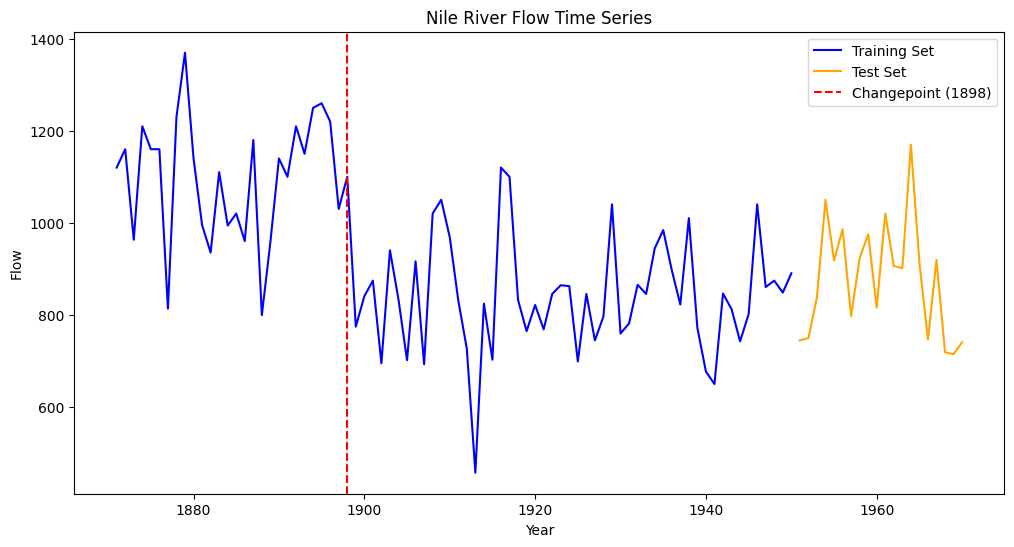

In [95]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(1871,1971)][:80],train, label='Training Set', color = "blue")
plt.plot([i for i in range(1871,1971)][80:],test, label='Test Set', color = "orange")
plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

The answer is taken from Wikipedia: 

**Aswan Low Dam, 1898–1902**

*The British began construction of the first dam across the Nile in 1898. Construction lasted until 1902 and the dam was opened on 10 December 1902*.

## 4. We will model the annual flow Xt and its measurement Yt in year t+1871, for t = 0, 1, . . . , 99, using the following univariate linear Gaussian state space model

In [96]:
import numpy as np
from particles import kalman

In [97]:
# first define the linear gaussian model
# dimensions
dx = 1
dy = 1

# initial distribution of X0 ~ N(mu0,Sigma0)
mu0 = np.zeros(dx)
Sigma0 = np.eye(dx)
almost_zero = 1e-15

In [98]:
# Define the initial state distribution
mu0 = 1120
Sigma0 = 1450

# Define the state space model function
def construct_ssm(sigma_X2, sigma_Y2):
    # Transition matrix (identity for univariate case)
    F = np.array([[1]])

    # Covariance matrix for X_t (process noise)
    SigmaX = np.array([[sigma_X2]])

    # Observation matrix (identity for univariate case)
    G = np.array([[1]])

    # Covariance matrix for Y_t (observation noise)
    SigmaY = np.array([[sigma_Y2]])

    # Define the linear Gaussian state space model
    ssm = kalman.MVLinearGauss(F=F, G=G, covX=SigmaX, covY=SigmaY, mu0=np.array([mu0]), cov0=np.array([[Sigma0]]))

    return ssm

We can try is is works : 

In [99]:
# construct model with some parameter values
ssm = construct_ssm(sigma_X2=1, sigma_Y2=20)

## 5. Let y0 , y1 , . . . , y79 denote the 80 measurements from 1871 to 1950 in our training dataset. Using the kalman module from the particles package, write a function that evaluates the log-likelihood log p(y0, y1, . . . , y79|θ) for any θ ∈ (0, ∞)2 with the Kalman filter. This function should take as argument theta a vector of size 2 and output a numerical value.

In [100]:
# learn parameters using maximum likelihood
def loglikelihood(theta,y):
    # get parameters

    sigma_X2, sigma_Y2 = theta

    # construct state space model
    ssm = construct_ssm(sigma_X2, sigma_Y2)

    # run Kalman filtering to evaluate the log-likelihood
    kf = kalman.Kalman(ssm=ssm, data=y)
    kf.filter()

    # return loglikelihood using sum
    return np.sum(kf.logpyt)

## 6. Compute the maximum likelihood estimator

In [101]:
from scipy.optimize import minimize
theta0 = [1450, 1500]

y_train = train.values

# Minimize the negative log-likelihood
result = minimize(lambda theta: -loglikelihood(theta, y_train), theta0, method='Nelder-Mead')

# The optimal parameters
optimal_theta = result.x

print("Optimal parameters:", optimal_theta)
print("Minimum log-likelihood:", -result.fun)

Optimal parameters: [ 1438.04422415 16003.77184309]
Minimum log-likelihood: -512.279738078976


## 7. Using the kalman module from the particles package, perform Kalman filtering and Kalman 􏰀 smoothing on the state space model (1) with the maximum likelihood estimator θ

In [102]:
ssm_estimator = construct_ssm(sigma_X2=optimal_theta[0], sigma_Y2=optimal_theta[1])
kf = kalman.Kalman(ssm=ssm_estimator, data=y_train)

# run Kalman filter
kf.filter()

In [103]:
# results 
print(type(kf.filt))
print(len(kf.filt))
print(kf.filt[0])

<class 'list'>
80
MeanAndCov(mean=array([1120.]), cov=array([[1329.53893182]]))


In [104]:
# mean vector at time 0
print(kf.filt[0].mean)

# covariance matrix at time 0 
print(kf.filt[0].cov)

[1120.]
[[1329.53893182]]


In [107]:
# extracts the filtering means
X_filtering = [filtering.mean[0] for filtering in kf.filt]

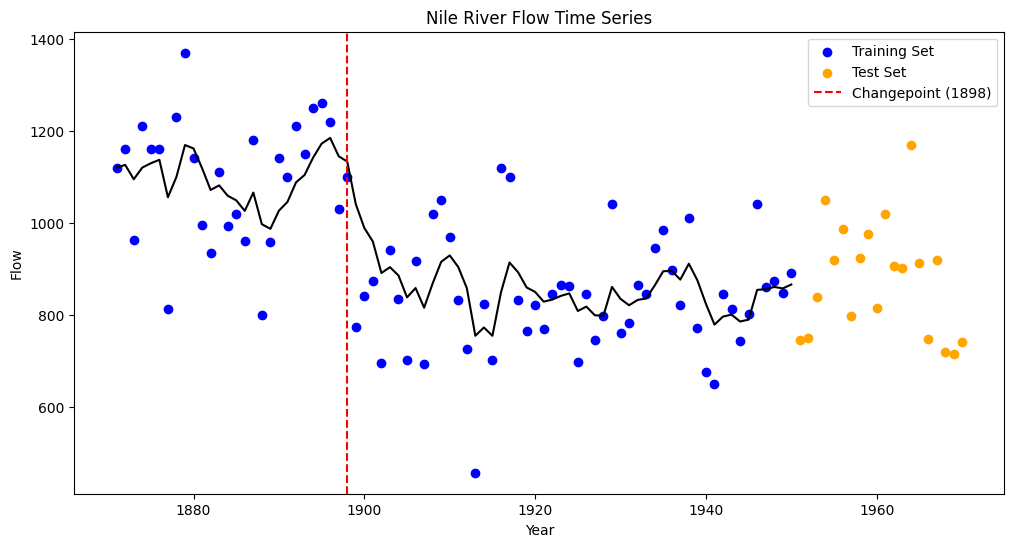

In [108]:

# Plot the time series
plt.figure(figsize=(12, 6))

plt.plot([i for i in range(1871,1971)][:80],X_filtering, 'k-')

plt.scatter([i for i in range(1871,1971)][:80],train, label='Training Set', color = "blue")
plt.scatter([i for i in range(1871,1971)][80:],test, label='Test Set', color = "orange")

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

In [109]:
# incremental log-likelihood values
print(type(kf.logpyt))
print(len(kf.logpyt))
print(kf.logpyt[0])

# log-likelihood value
print(np.sum(kf.logpyt))

<class 'list'>
80
[[-5.80259406]]
-512.279738078976


In [110]:
# run Kalman smoothing
kf.smoother()

# results 
print(type(kf.smth))
print(len(kf.smth))

# smoothing mean at time 0
print(kf.smth[0].mean)

# smoothing cov at time 0
print(kf.smth[0].cov)

<class 'list'>
80
[1117.74356521]
[[1073.3339082]]


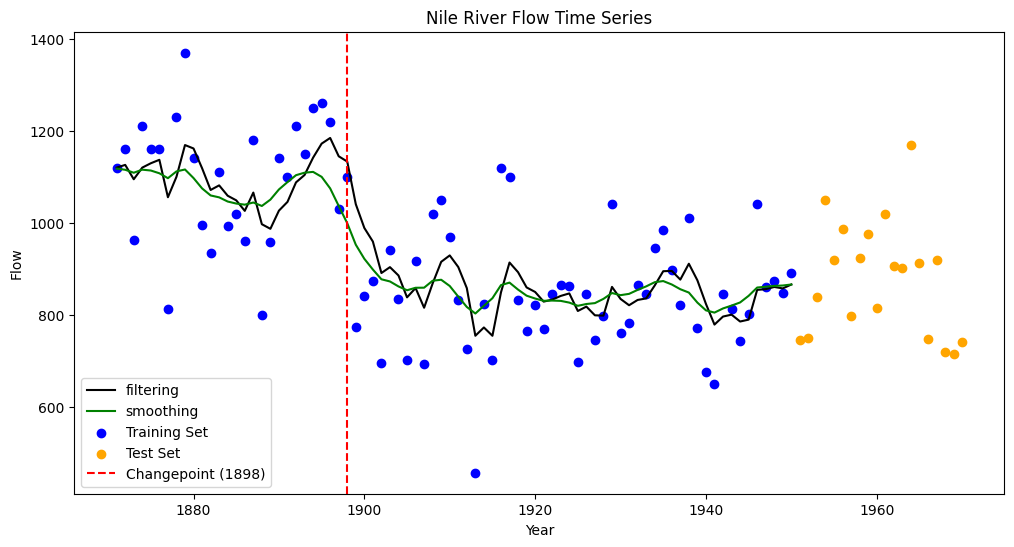

In [111]:
# extracts the smoothing means
X_smoothing = [smoothing.mean[0] for smoothing in kf.smth]

# Plot the time series
plt.figure(figsize=(12, 6))

plt.plot([i for i in range(1871,1971)][:80],X_filtering, 'k-', label = "filtering")
plt.plot([i for i in range(1871,1971)][:80],X_smoothing, 'g-', label = "smoothing")

plt.scatter([i for i in range(1871,1971)][:80],train, label='Training Set', color = "blue")
plt.scatter([i for i in range(1871,1971)][80:],test, label='Test Set', color = "orange")

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

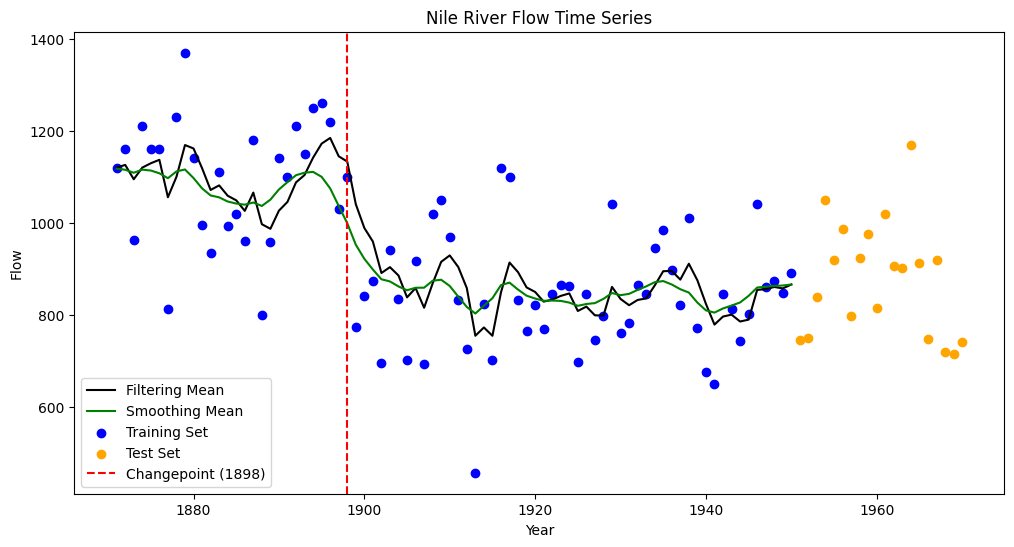

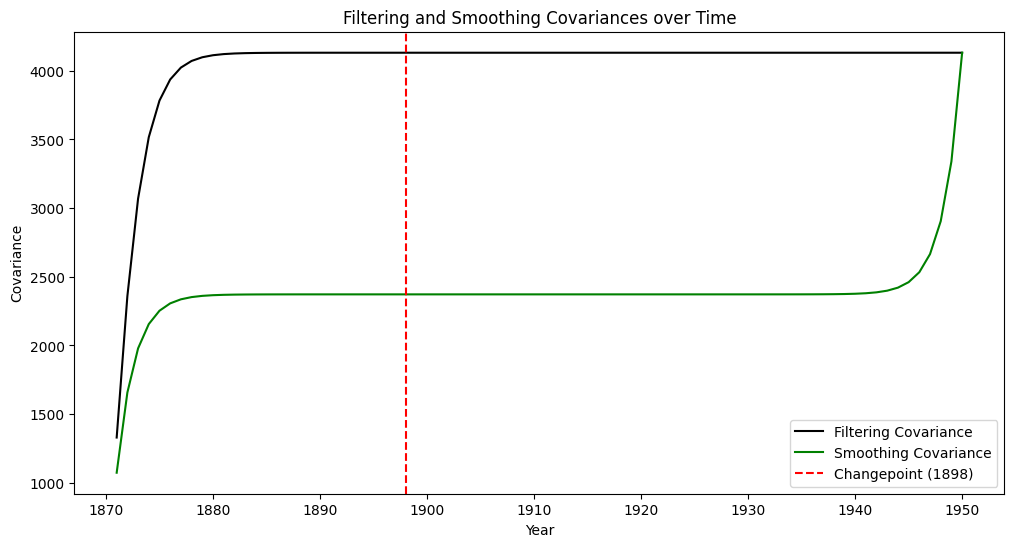

In [112]:
# Extract smoothing means and covariances
smoothing_means = [smoothing.mean[0] for smoothing in kf.smth]
smoothing_cov = [smoothing.cov[0] for smoothing in kf.smth]

# Assuming you also have filtering results in kf.filt
filtering_means = [filtering.mean[0] for filtering in kf.filt]
filtering_cov = [filtering.cov[0] for filtering in kf.filt]

# Define the time range
years = list(range(1871, 1971))

# Plot the filtering and smoothing means, training, and test sets
plt.figure(figsize=(12, 6))

plt.plot(years[:80], filtering_means, 'k-', label='Filtering Mean')
plt.plot(years[:80], smoothing_means, 'g-', label='Smoothing Mean')

plt.scatter(years[:80], train, label='Training Set', color='blue')
plt.scatter(years[80:], test, label='Test Set', color='orange')

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

# Plot the covariances
plt.figure(figsize=(12, 6))

plt.plot(years[:80], filtering_cov, 'k-', label='Filtering Covariance')
plt.plot(years[:80], smoothing_cov, 'g-', label='Smoothing Covariance')

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Covariance')
plt.title('Filtering and Smoothing Covariances over Time')
plt.legend()
plt.show()


Both the filtering and smoothing variances start from a lower value and increase rapidly at the beginning. This initial increase can be attributed to the model's need to learn the state from limited initial observations, leading to high uncertainty.

The smoothing variance stabilizes much earlier compared to the filtering variance. This is because the smoothing process utilizes information from the entire dataset, providing a more accurate and less uncertain estimate of the state.

The filtering variance continues to be significantly higher than the smoothing variance throughout most of the time series. This is because the filtering process only uses past and present data up to time 
𝑡
t to estimate the state, inherently carrying more uncertainty as it doesn't have future observations to refine the estimates.

Both variances show an increase towards the end of the series. The filtering variance increases more steeply, reflecting increasing uncertainty as the series progresses without future observations to refine the state estimates.

Filtering Variance: At any time 
𝑡
t, the filtering variance uses only the information available up to that point. This leads to higher uncertainty as it cannot correct or adjust its estimates with future data points.
Smoothing Variance: The smoothing variance benefits from the entire dataset, including future observations. This allows for more precise adjustments and lower overall uncertainty.


## 10. Using the state space model (1) with the maximum likelihood estimator θ, compute the predictive mean E[Yt|θ,y0,y1,...,y79] and the predictive variance Var[Yt|θ,y0,y1,...,y79], for t = 80, . . . , 99, of the 20 measurements from 1951 to 1970.

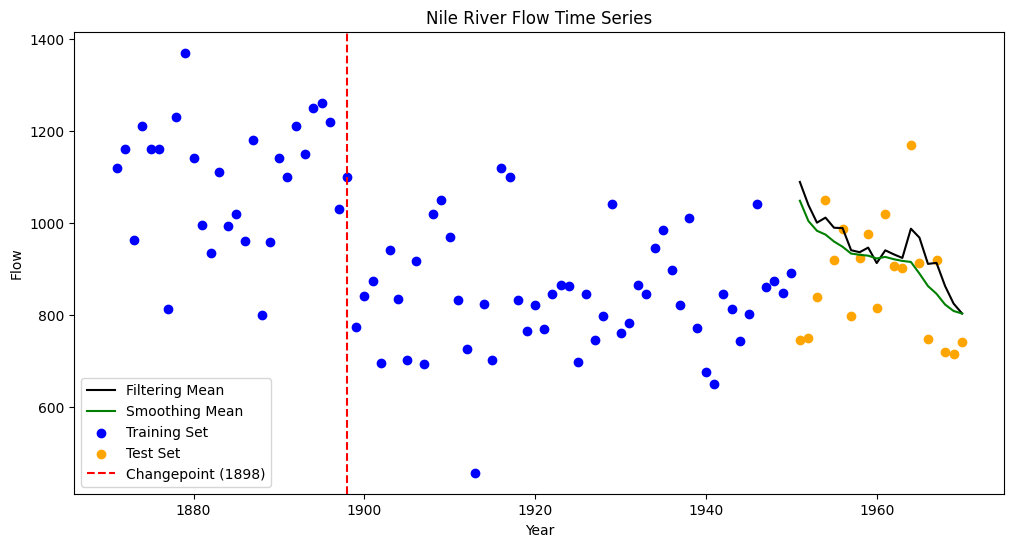

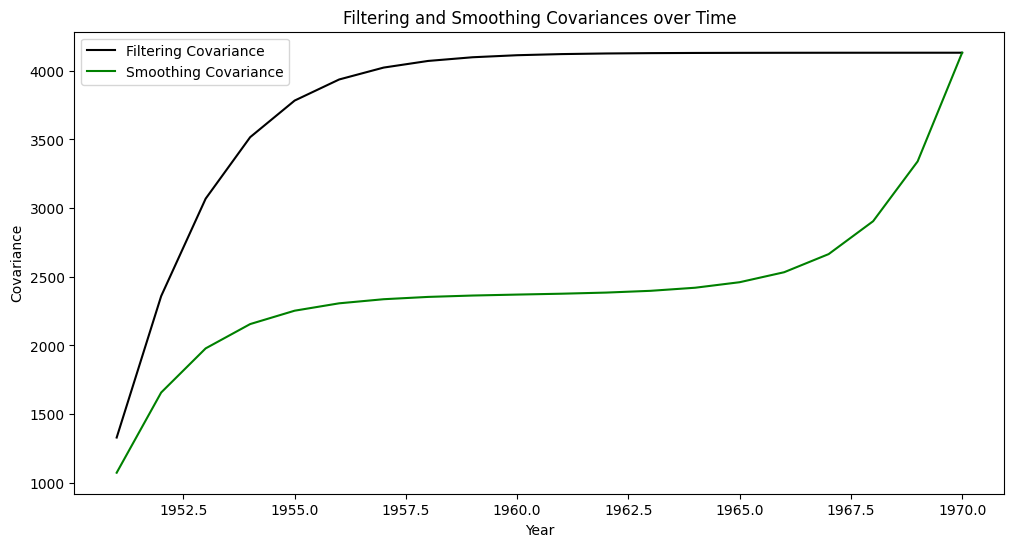

In [113]:
y_test = test.values

ssm_estimator = construct_ssm(sigma_X2=optimal_theta[0], sigma_Y2=optimal_theta[1])
kf = kalman.Kalman(ssm=ssm_estimator, data=y_test)

# run Kalman filter
kf.filter()

# run Kalman smoothing
kf.smoother()

# Extract smoothing means and covariances
smoothing_means = [smoothing.mean[0] for smoothing in kf.smth]
smoothing_cov = [smoothing.cov[0] for smoothing in kf.smth]

# Assuming you also have filtering results in kf.filt
filtering_means = [filtering.mean[0] for filtering in kf.filt]
filtering_cov = [filtering.cov[0] for filtering in kf.filt]

# Define the time range
years = list(range(1871, 1971))

# Plot the filtering and smoothing means, training, and test sets
plt.figure(figsize=(12, 6))

plt.plot(years[80:], filtering_means, 'k-', label='Filtering Mean')
plt.plot(years[80:], smoothing_means, 'g-', label='Smoothing Mean')

plt.scatter(years[:80], train, label='Training Set', color='blue')
plt.scatter(years[80:], test, label='Test Set', color='orange')

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

# Plot the covariances
plt.figure(figsize=(12, 6))

plt.plot(years[80:], filtering_cov, 'k-', label='Filtering Covariance')
plt.plot(years[80:], smoothing_cov, 'g-', label='Smoothing Covariance')

plt.xlabel('Year')
plt.ylabel('Covariance')
plt.title('Filtering and Smoothing Covariances over Time')
plt.legend()
plt.show()


## 11. Using the predictive means and variances, compare the predictive distributions with the 20 measurements from 1951 to 1970 in our testing dataset.

The filtering mean seems to adapt more slowly and is less smooth compared to the smoothing mean.

The filtering covariance is consistently higher than the smoothing covariance, indicating greater uncertainty in the filtering predictions.
The lower smoothing covariance reflects more confidence in the smoothing predictions due to the use of future data points in the estimation process.

Most of the actual measurements from the test set (orange dots) fall within the expected range of the predictions, though specific deviations and outliers are present.
These deviations may indicate periods where the model's assumptions are less accurate or where unexpected events impacted the river flow.

The comparison indicates that the state space model with maximum likelihood estimation effectively predicts the Nile River flow, with the smoothing approach offering more reliable estimates due to lower variance and better utilization of the full dataset.

****